In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
ind_return = erk.get_ind30_returns()


In [50]:
tmi_return = erk.get_total_market_index_returns()

In [51]:
tmi_return

1926-07    0.031375
1926-08    0.028957
1926-09    0.005566
1926-10   -0.028504
1926-11    0.028039
             ...   
2018-08    0.036951
2018-09    0.002108
2018-10   -0.074292
2018-11    0.019003
2018-12   -0.092911
Freq: M, Length: 1110, dtype: float64

In [52]:
risky_r = ind_return["2000":][["Steel","Fin","Beer"]]
risky_r.shape

(228, 3)

In [53]:
# Create Safe Asset Data Frame that has exactly the same shape as Risk Asset
safe_r = pd.DataFrame().reindex_like(risky_r)

In [54]:
'''
give every values in safe_r the same number
'''
### Initialize ###
safe_r[:] = 0.03/12 #monthly data
start = 1000 # start with 1000 dollar
floor = 0.8 # Percentage %

1. Cushion : AssetValue - Floor Value
2. Compue the Allocation to Safe and Risky Assets --> m*risk budget
3. Recompute the Asset Value based on the returns

In [55]:
def compound1(r):
    return (1+r).prod()-1

def compound2(r):
    '''
    log1p(r) = log(1+r)
    expm1(x) = exp(x-1)
    '''
    return np.expm1(np.log1p(r).sum())

In [56]:
# check if the 2 function return exactly the same value

compound1(risky_r)


Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [57]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [58]:
%timeit compound1(risky_r)

429 µs ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [59]:
%timeit compound2(risky_r)

416 µs ± 8.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### CPPI

In [65]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r) #weights in risky asset

for step in range(n_steps):
    cushion = (account_value-floor_value)/account_value
    risky_weight = m*cushion
    risky_weight = np.minimum(risky_weight,1) # risky weight is not more than 1
    risky_weight = np.maximum(risky_weight,0) # risky weight is not less than 0
    safe_weight = 1-risky_weight
    risky_allocation = account_value*risky_weight
    safe_allocation = account_value*safe_weight
    ### update the account value for this time step
    account_value = risky_allocation*(1+risky_r.iloc[step]) + safe_allocation*(1+safe_r.iloc[step])
    ### save the values to plot the history
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_weight
    account_history.iloc[step] = account_value


In [66]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


<AxesSubplot: >

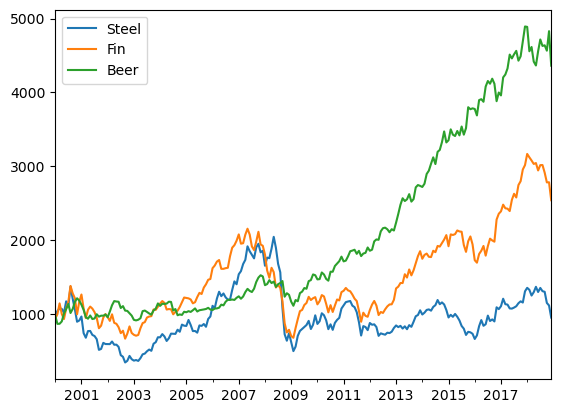

In [67]:
risky_wealth = start*(1+risky_r).cumprod()
riskey_wealth.plot()

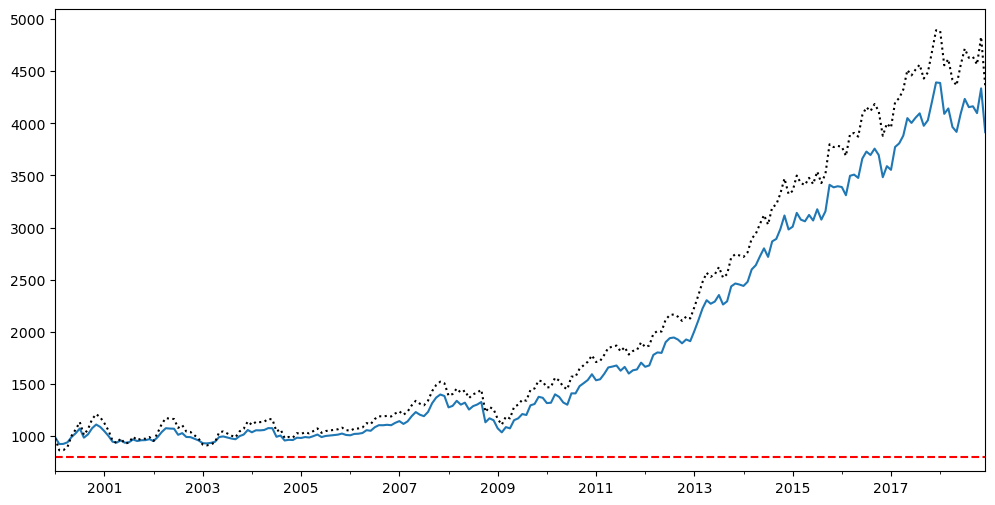

In [74]:
ax = account_history["Beer"].plot(figsize =(12,6))
risky_wealth["Beer"].plot(ax=ax, style = "k:")
#horizontal line
ax.axhline(y=floor_value, color = "r", linestyle="--")


- dotted line: if we just invest in Beer alone than there is more variation.
- blue line: if we invest in Beer and the safe asset than obviously there is much less volatile.

<AxesSubplot: >

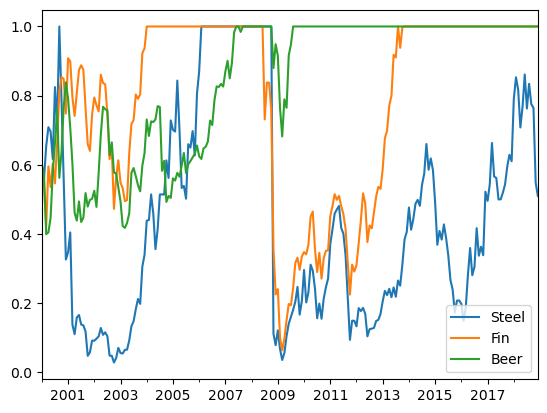

In [75]:
risky_w_history.plot()

- in the early days, the weight of risky asset is somewhere in the middle.
- Beer and Fin ended up 100 percent allocation to the risky asset (correlation is then 100%)

### in real life: the floor will be updated

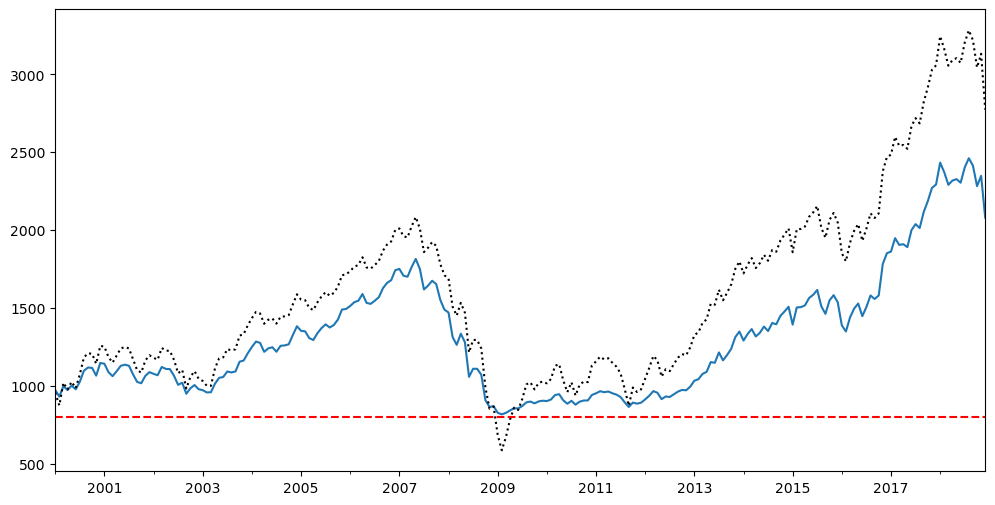

In [76]:
ax = account_history["Fin"].plot(figsize =(12,6))
risky_wealth["Fin"].plot(ax=ax, style = "k:")
#horizontal line
ax.axhline(y=floor_value, color = "r", linestyle="--")

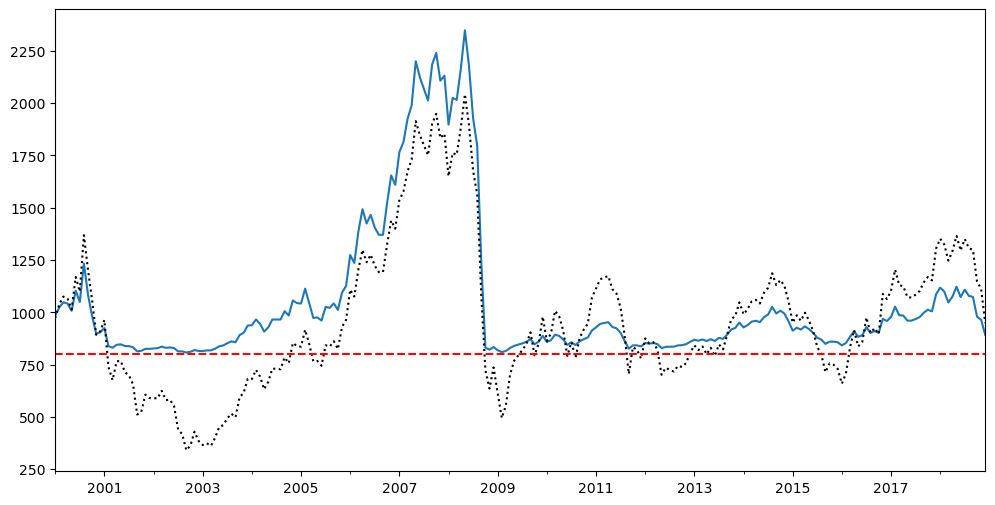

In [77]:
ax = account_history["Steel"].plot(figsize =(12,6))
risky_wealth["Steel"].plot(ax=ax, style = "k:")
#horizontal line
ax.axhline(y=floor_value, color = "r", linestyle="--")

- in this case CPPI (dotted) is the best choice, it helps prevent going under the floor.

In [78]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [79]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


<AxesSubplot: >

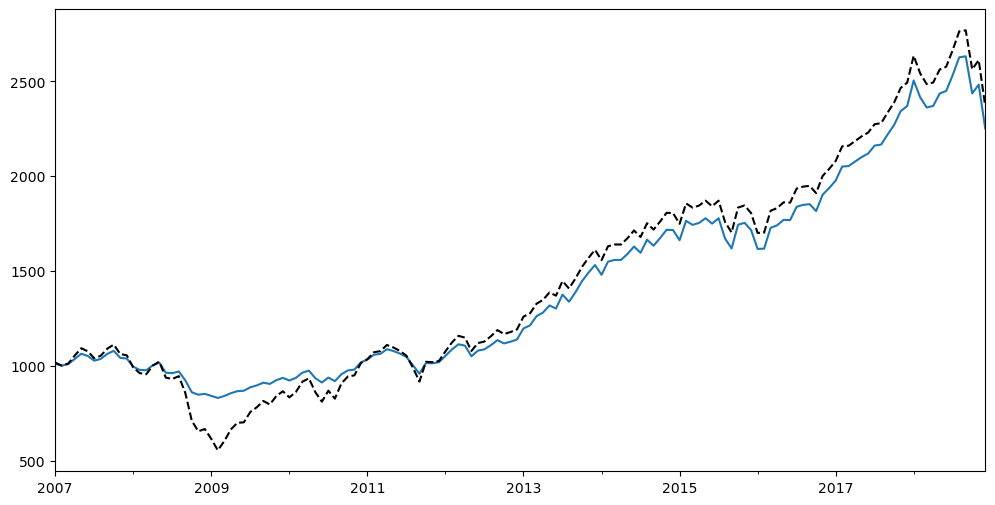

In [80]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize=(12,6), legend=False)
btr["Risk Wealth"].plot(ax=ax, style="k--", legend=False)

In [81]:
erk.summary_stats(btr["Risk Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [82]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


# Max Drawdown Constraints

In [83]:
btr = erk.run_cppi(ind_return["2007":][["Steel","Fin","Beer"]], drawdown=0.25)

<AxesSubplot: >

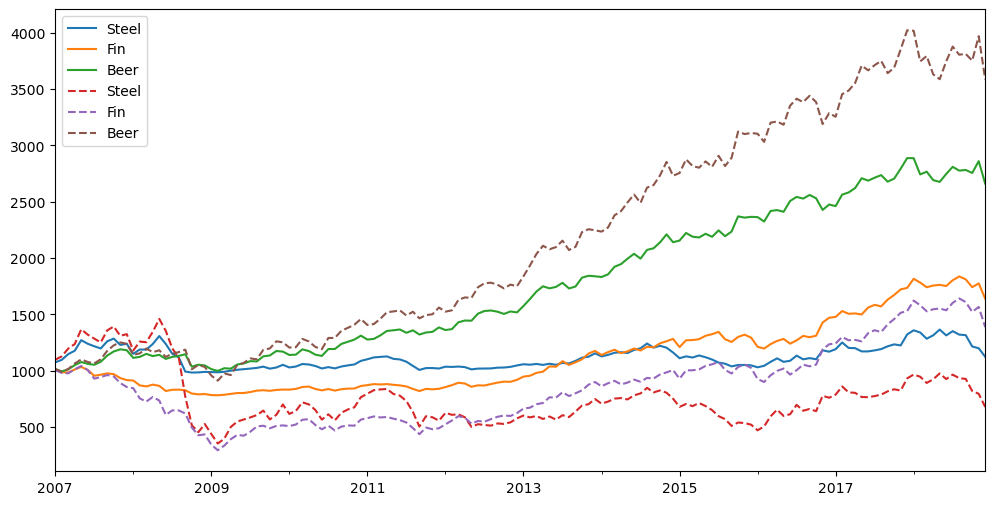

In [84]:
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risk Wealth"].plot(ax=ax, style = "--")

In [85]:
erk.summary_stats(btr["Risk Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [86]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186


- The drawdown are less than 25% when we give it a Max Drawdown Constrain = 25%.
- This Contraint optimalize the CPPI strategy.

### CPPI is important for downside protection!